In [1]:
import csv
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')


# Extract WordNet relationships
def extract_wordnet_data():
    data = []
    for synset in wn.all_synsets():
        # print(synset.lemmas())
        # break
        for lemma in synset.lemmas():
            # Synonyms
            for synonym in synset.lemmas():
                if lemma != synonym:
                    data.append([lemma.name(), synonym.name(), "synonym", synset.definition(), synset.definition()])
            
            # Antonyms
            for antonym in lemma.antonyms():
                data.append([lemma.name(), antonym.name(), "antonym", synset.definition(), antonym.synset().definition()])
            
            # Hypernyms and Hyponyms
            for hypernym in synset.hypernyms():
                data.append([synset.name().split('.')[0], hypernym.name().split('.')[0], "hypernym", synset.definition(), hypernym.definition()])
                
    
    return data

# Write to CSV
def create_csv(data, filename="wordnet_dataset.csv"):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Word 1", "Word 2", "Relationship", "Definition 1", "Definition 2"])
        writer.writerows(data)

# Generate and save the dataset
data = extract_wordnet_data()
create_csv(data)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mccry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Adjust num_labels

# Tokenize and prepare dataset
# Define training args, Trainer, and fine-tune

# Load the CSV file
data = pd.read_csv("wordnet_dataset.csv")

# Define a mapping for relationship labels
label_mapping = {"synonym": 0, "antonym": 1, "hypernym": 2}

# Map relationships to numerical labels
data["label"] = data["Relationship"].map(label_mapping)

# Concatenate Word 1 and Word 2 with definitions (optional)
data["text"] = data["Word 1"] + " [SEP] " + data["Word 2"]
data["text"] = data["text"].fillna("")
data = data[data["text"].str.strip() != ""]


# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(data[["text", "label"]])
# print(len(dataset))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

fraction = 0.1
dataset = dataset.select(range(int(len(dataset) * fraction)))
tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/48123 [00:00<?, ? examples/s]

In [4]:
# Split into train and validation sets
split_dataset = tokenized_dataset.train_test_split(test_size=0.3)
validation_test_split = split_dataset["test"].train_test_split(test_size=0.33)

train_dataset = split_dataset["train"]
val_dataset = validation_test_split["train"]
test_dataset = validation_test_split["test"]

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# Set the fraction of the dataset to use
fraction = 0.01


# Select a fraction of the training and validation datasets
train_dataset_sample = train_dataset.select(range(int(len(train_dataset) * fraction)))
val_dataset_sample = val_dataset.select(range(int(len(val_dataset) * fraction)))
test_dataset_sample = test_dataset.select(range(int(len(test_dataset) * 0.1)))


label_mapping_reverse = {v: k for k, v in label_mapping.items()}


# print(train_dataset_sample[0])
# Dynamically determine label names from the dataset
unique_labels = sorted(set(train_dataset_sample["label"]))  # Ensure sorted labels
# print(unique_labels)
target_names = [label_mapping_reverse[label] for label in unique_labels]  # Reverse map labels to class names

# print(target_names)
# print(f"Training on {len(train_dataset_sample)} samples and validating on {len(val_dataset_sample)} samples and testing on {len(test_dataset_sample)} samples")


Train samples: 33686, Validation samples: 9672, Test samples: 4765


In [5]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_mapping))

def freeze_bert_layers(model, freeze_up_to=0):
    """Freezes layers of the BERT model up to a given index."""
    for name, param in model.bert.named_parameters():
        layer_num = int(name.split('.')[2]) if 'encoder.layer' in name else -1
        if layer_num < freeze_up_to:
            param.requires_grad = False

freeze_bert_layers(model, freeze_up_to=8)

# Print the status of layers
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert.embeddings.word_embeddings.weight: Frozen
bert.embeddings.position_embeddings.weight: Frozen
bert.embeddings.token_type_embeddings.weight: Frozen
bert.embeddings.LayerNorm.weight: Frozen
bert.embeddings.LayerNorm.bias: Frozen
bert.encoder.layer.0.attention.self.query.weight: Frozen
bert.encoder.layer.0.attention.self.query.bias: Frozen
bert.encoder.layer.0.attention.self.key.weight: Frozen
bert.encoder.layer.0.attention.self.key.bias: Frozen
bert.encoder.layer.0.attention.self.value.weight: Frozen
bert.encoder.layer.0.attention.self.value.bias: Frozen
bert.encoder.layer.0.attention.output.dense.weight: Frozen
bert.encoder.layer.0.attention.output.dense.bias: Frozen
bert.encoder.layer.0.attention.output.LayerNorm.weight: Frozen
bert.encoder.layer.0.attention.output.LayerNorm.bias: Frozen
bert.encoder.layer.0.intermediate.dense.weight: Frozen
bert.encoder.layer.0.intermediate.dense.bias: Frozen
bert.encoder.layer.0.output.dense.weight: Frozen
bert.encoder.layer.0.output.dense.bias: 

In [9]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert-wordnet-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.001,
    logging_dir="./logs",
    num_train_epochs=10,
    load_best_model_at_end=True,
    warmup_steps=100,
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_sample,
    eval_dataset=val_dataset_sample,
    tokenizer=tokenizer
)

trainer.train()

# Save the fine-tuned model
model.save_pretrained("./bert-wordnet-finetuned")
tokenizer.save_pretrained("./bert-wordnet-finetuned")


  0%|          | 0/210 [00:00<?, ?it/s]

{'loss': 0.3142, 'grad_norm': 1.591407060623169, 'learning_rate': 2.1000000000000002e-06, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.302346795797348, 'eval_runtime': 0.4193, 'eval_samples_per_second': 228.978, 'eval_steps_per_second': 14.311, 'epoch': 1.0}
{'loss': 0.3121, 'grad_norm': 2.5179994106292725, 'learning_rate': 4.2000000000000004e-06, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.30025842785835266, 'eval_runtime': 0.4248, 'eval_samples_per_second': 225.989, 'eval_steps_per_second': 14.124, 'epoch': 2.0}
{'loss': 0.3023, 'grad_norm': 1.6631137132644653, 'learning_rate': 6.300000000000001e-06, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2922807037830353, 'eval_runtime': 0.4192, 'eval_samples_per_second': 229.025, 'eval_steps_per_second': 14.314, 'epoch': 3.0}
{'loss': 0.2924, 'grad_norm': 2.782123565673828, 'learning_rate': 8.400000000000001e-06, 'epoch': 4.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2847661077976227, 'eval_runtime': 0.4191, 'eval_samples_per_second': 229.045, 'eval_steps_per_second': 14.315, 'epoch': 4.0}
{'loss': 0.2716, 'grad_norm': 2.1610031127929688, 'learning_rate': 9.949107209404664e-06, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.27398213744163513, 'eval_runtime': 0.4251, 'eval_samples_per_second': 225.823, 'eval_steps_per_second': 14.114, 'epoch': 5.0}
{'loss': 0.2573, 'grad_norm': 1.586068034172058, 'learning_rate': 8.683705689382025e-06, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2654883563518524, 'eval_runtime': 0.4242, 'eval_samples_per_second': 226.291, 'eval_steps_per_second': 14.143, 'epoch': 6.0}
{'loss': 0.2498, 'grad_norm': 2.216377019882202, 'learning_rate': 6.132483837128823e-06, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.25639793276786804, 'eval_runtime': 0.4254, 'eval_samples_per_second': 225.664, 'eval_steps_per_second': 14.104, 'epoch': 7.0}
{'loss': 0.2415, 'grad_norm': 1.9160346984863281, 'learning_rate': 3.1859614732467957e-06, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.24978329241275787, 'eval_runtime': 0.4559, 'eval_samples_per_second': 210.574, 'eval_steps_per_second': 13.161, 'epoch': 8.0}
{'loss': 0.239, 'grad_norm': 1.723503589630127, 'learning_rate': 8.7264051518613e-07, 'epoch': 9.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.24807167053222656, 'eval_runtime': 0.4263, 'eval_samples_per_second': 225.19, 'eval_steps_per_second': 14.074, 'epoch': 9.0}
{'loss': 0.2341, 'grad_norm': 1.6990138292312622, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.24791859090328217, 'eval_runtime': 0.6259, 'eval_samples_per_second': 153.37, 'eval_steps_per_second': 9.586, 'epoch': 10.0}
{'train_runtime': 53.4193, 'train_samples_per_second': 62.899, 'train_steps_per_second': 3.931, 'train_loss': 0.2714232535589309, 'epoch': 10.0}


('./bert-wordnet-finetuned\\tokenizer_config.json',
 './bert-wordnet-finetuned\\special_tokens_map.json',
 './bert-wordnet-finetuned\\vocab.txt',
 './bert-wordnet-finetuned\\added_tokens.json')

In [10]:
log_history = trainer.state.log_history
eval_logs = [log for log in log_history if "loss" in log]

for epoch, log in enumerate(eval_logs, 1):
    print(f"Epoch {epoch}: {log}")

Epoch 1: {'loss': 0.3142, 'grad_norm': 1.591407060623169, 'learning_rate': 2.1000000000000002e-06, 'epoch': 1.0, 'step': 21}
Epoch 2: {'loss': 0.3121, 'grad_norm': 2.5179994106292725, 'learning_rate': 4.2000000000000004e-06, 'epoch': 2.0, 'step': 42}
Epoch 3: {'loss': 0.3023, 'grad_norm': 1.6631137132644653, 'learning_rate': 6.300000000000001e-06, 'epoch': 3.0, 'step': 63}
Epoch 4: {'loss': 0.2924, 'grad_norm': 2.782123565673828, 'learning_rate': 8.400000000000001e-06, 'epoch': 4.0, 'step': 84}
Epoch 5: {'loss': 0.2716, 'grad_norm': 2.1610031127929688, 'learning_rate': 9.949107209404664e-06, 'epoch': 5.0, 'step': 105}
Epoch 6: {'loss': 0.2573, 'grad_norm': 1.586068034172058, 'learning_rate': 8.683705689382025e-06, 'epoch': 6.0, 'step': 126}
Epoch 7: {'loss': 0.2498, 'grad_norm': 2.216377019882202, 'learning_rate': 6.132483837128823e-06, 'epoch': 7.0, 'step': 147}
Epoch 8: {'loss': 0.2415, 'grad_norm': 1.9160346984863281, 'learning_rate': 3.1859614732467957e-06, 'epoch': 8.0, 'step': 16

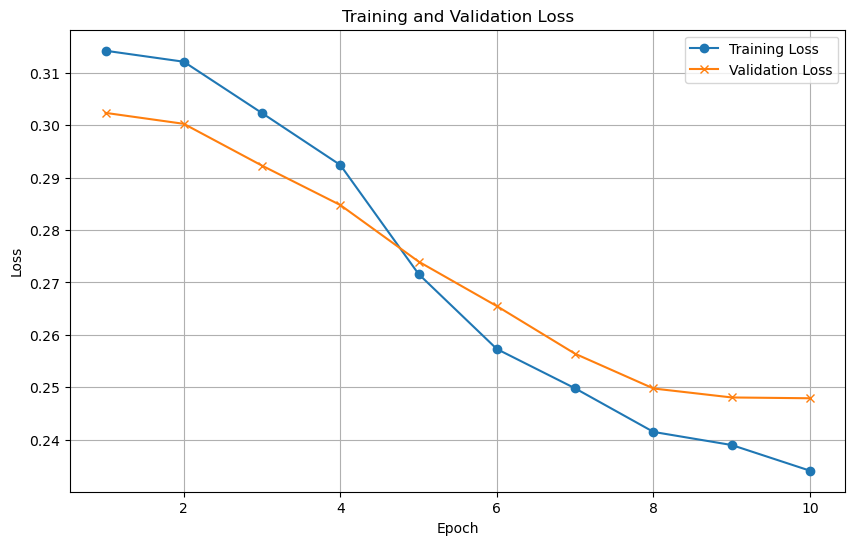

In [11]:
import matplotlib.pyplot as plt

# Extract log history from the trainer
log_history = trainer.state.log_history

# Separate training and evaluation losses
training_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
epochs = range(1, len(training_losses) + 1)

# Plot training and evaluation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label="Validation Loss", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification

def compute_classification_metrics(model, dataset, tokenizer):
    # Ensure model is in evaluation mode
    model.eval()
    
    # Get the device where the model is located
    device = next(model.parameters()).device

    all_predictions = []
    all_labels = []

    for example in dataset:
        # Tokenize the input text
        inputs = tokenizer(
            example["text"],  # Adjust column name to match your dataset
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )
        
        # Move inputs to the same device as the model
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_label = torch.argmax(logits, dim=-1).item()
        
        # Store predictions and ground truth labels
        all_predictions.append(predicted_label)
        all_labels.append(example["label"])
    
    # Compute classification metrics
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=target_names,  # Adjust for your label names
        output_dict=True
    )
    return report


model = BertForSequenceClassification.from_pretrained("./bert-wordnet-finetuned")
tokenizer = BertTokenizer.from_pretrained("./bert-wordnet-finetuned")
# Evaluate the model on the test dataset
test_report = compute_classification_metrics(model, test_dataset_sample, tokenizer)

# Print metrics
print("Classification Report:")
for label, metrics in test_report.items():
    if isinstance(metrics, dict):  # Skip summary keys like 'accuracy'
        print(f"{label}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")


Classification Report:
synonym:
  precision: 0.9262
  recall: 1.0000
  f1-score: 0.9617
  support: 439.0000
antonym:
  precision: 1.0000
  recall: 0.0541
  f1-score: 0.1026
  support: 37.0000
macro avg:
  precision: 0.9631
  recall: 0.5270
  f1-score: 0.5321
  support: 476.0000
weighted avg:
  precision: 0.9319
  recall: 0.9265
  f1-score: 0.8949
  support: 476.0000


In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned model and tokenizer
model_path = "./bert-wordnet-finetuned"  # Path to your fine-tuned model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)  # Ensure the correct model type
model.eval()  # Set model to evaluation mode

# Function to compute similarity score
def compute_similarity(text1, text2):
    # Tokenize the input sentences
    inputs = tokenizer(text1, text2, return_tensors="pt", padding=True, truncation=True)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Handle logits for regression or classification
    if outputs.logits.shape[-1] == 1:  # Regression model
        similarity_score = outputs.logits.squeeze().item()  # Squeeze to get a scalar value
    elif outputs.logits.shape[-1] > 1:  # Classification model
        probabilities = torch.softmax(outputs.logits, dim=-1)  # Compute probabilities
        similarity_score = probabilities[0, 1].item()  # Use the probability of the "similar" class
    else:
        raise ValueError("Unexpected model output shape.")
    
    return similarity_score

# Function to compute cosine similarity for embeddings
def compute_cosine_similarity(text1, text2):
    # Tokenize the input sentences
    inputs1 = tokenizer(text1, return_tensors="pt", truncation=True, padding=True)
    inputs2 = tokenizer(text2, return_tensors="pt", truncation=True, padding=True)

    # Forward pass through the model
    with torch.no_grad():
        embeddings1 = model.bert(**inputs1).last_hidden_state[:, 0, :]  # CLS token embedding
        embeddings2 = model.bert(**inputs2).last_hidden_state[:, 0, :]  # CLS token embedding

    # Compute cosine similarity
    cosine_similarity = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).item()
    return cosine_similarity

# Define example data
student_texts = [
    "Machine learning is a subfield of artificial intelligence.",
    "Deep learning is a type of machine learning that uses neural networks.",
    "Neural networks are inspired by the structure of the human brain.",
]

reference_texts = [
    "Machine learning is a subfield of artificial intelligence.",
    "Artificial intelligence includes machine learning and deep learning.",
    "Neural networks mimic the human brain's structure and function.",
    "Machine learning uses data and algorithms to learn patterns.",
]

# Threshold for potential plagiarism
similarity_threshold = 0.75  # Adjust based on experimentation

# Check for plagiarism
for i, student_text in enumerate(student_texts):
    print(f"\nStudent Text {i + 1}: {student_text}")
    for j, reference_text in enumerate(reference_texts):
        similarity = compute_cosine_similarity(student_text, reference_text)
        # cosine_similarity = compute_cosine_similarity(student_text, reference_text)
        status = "Potential Plagiarism" if similarity >= similarity_threshold else "Not Plagiarized"
        print(f"  Reference {j + 1}: {reference_text}")
        print(f"    Similarity Score (Model): {similarity:.2f} -> {status}")
        # print(f"    Cosine Similarity (Embeddings): {cosine_similarity:.2f}")



Student Text 1: Machine learning is a subfield of artificial intelligence.
  Reference 1: Machine learning is a subfield of artificial intelligence.
    Similarity Score (Model): 1.00 -> Potential Plagiarism
  Reference 2: Artificial intelligence includes machine learning and deep learning.
    Similarity Score (Model): 0.77 -> Potential Plagiarism
  Reference 3: Neural networks mimic the human brain's structure and function.
    Similarity Score (Model): 0.71 -> Not Plagiarized
  Reference 4: Machine learning uses data and algorithms to learn patterns.
    Similarity Score (Model): 0.73 -> Not Plagiarized

Student Text 2: Deep learning is a type of machine learning that uses neural networks.
  Reference 1: Machine learning is a subfield of artificial intelligence.
    Similarity Score (Model): 0.94 -> Potential Plagiarism
  Reference 2: Artificial intelligence includes machine learning and deep learning.
    Similarity Score (Model): 0.74 -> Not Plagiarized
  Reference 3: Neural netw

In [15]:
from sklearn.metrics import classification_report
import torch

def evaluate_model(model, dataset, tokenizer, target_names):
    model.eval()  # Ensure the model is in evaluation mode
    
    # Get the device where the model is located
    device = next(model.parameters()).device
    
    all_predictions = []
    all_labels = []

    for example in dataset:
        # Tokenize the input text
        inputs = tokenizer(
            example["text"],  # Adjust column name to match your dataset
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )
        
        # Move inputs to the same device as the model
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_label = torch.argmax(logits, dim=-1).item()  # Prediction
        
        # Collect predictions and ground truth labels
        all_predictions.append(predicted_label)
        all_labels.append(example["label"])  # Assuming your dataset has a 'label' field

    # Compute and return the classification report
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=target_names,
        output_dict=True
    )
    return report


from transformers import BertTokenizer, BertForSequenceClassification

# Base BERT model (not fine-tuned)
base_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
base_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
base_model.to("cuda" if torch.cuda.is_available() else "cpu")

# Fine-tuned BERT model
fine_tuned_model_path = "./bert-wordnet-finetuned"
fine_tuned_model = BertForSequenceClassification.from_pretrained(fine_tuned_model_path)
fine_tuned_tokenizer = BertTokenizer.from_pretrained(fine_tuned_model_path)
fine_tuned_model.to("cuda" if torch.cuda.is_available() else "cpu")


# Evaluate base model
base_model_report = evaluate_model(base_model, test_dataset_sample, base_tokenizer, target_names)

# Evaluate fine-tuned model
fine_tuned_model_report = evaluate_model(fine_tuned_model, test_dataset_sample, fine_tuned_tokenizer, target_names)

# Print classification reports
print("Base Model Classification Report:")
for label, metrics in base_model_report.items():
    if isinstance(metrics, dict):  # Skip summary keys like 'accuracy'
        print(f"{label}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")

print("\nFine-Tuned Model Classification Report:")
for label, metrics in fine_tuned_model_report.items():
    if isinstance(metrics, dict):  # Skip summary keys like 'accuracy'
        print(f"{label}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model Classification Report:
synonym:
  precision: 0.9062
  recall: 0.1982
  f1-score: 0.3252
  support: 439.0000
antonym:
  precision: 0.0737
  recall: 0.7568
  f1-score: 0.1343
  support: 37.0000
macro avg:
  precision: 0.4900
  recall: 0.4775
  f1-score: 0.2298
  support: 476.0000
weighted avg:
  precision: 0.8415
  recall: 0.2416
  f1-score: 0.3104
  support: 476.0000

Fine-Tuned Model Classification Report:
synonym:
  precision: 0.9262
  recall: 1.0000
  f1-score: 0.9617
  support: 439.0000
antonym:
  precision: 1.0000
  recall: 0.0541
  f1-score: 0.1026
  support: 37.0000
macro avg:
  precision: 0.9631
  recall: 0.5270
  f1-score: 0.5321
  support: 476.0000
weighted avg:
  precision: 0.9319
  recall: 0.9265
  f1-score: 0.8949
  support: 476.0000
